In [249]:
%load_ext autoreload
%autoreload 2

from loader import Data, load_data_from_json
from ploter import Ploter
import numpy as np

import pandas as pd
from model import Model
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
data: Data = load_data_from_json("../data/toy_instance.json")

In [251]:
print(data)

Data(N=5, E=3, Q=3, P=5, _qualifications=[[0, 1, 2], [0, 1], [2]], _conges=[[], [0], [1]], _duree=[[1, 1, 1], [1, 2, 0], [1, 0, 2], [0, 2, 1], [0, 0, 2]], _gain=[20, 15, 15, 20, 10], _due_date=[2, 2, 3, 2, 4], _penalty=[3, 3, 3, 3, 3], _employees_names=['Olivia', 'Liam', 'Emma'], _qualifications_names=['A', 'B', 'C'], _projects_names=['Job1', 'Job2', 'Job3', 'Job4', 'Job5'], M=10000000.0)


In [252]:
m = Model(data)

In [253]:
m.constraint_cant_work_more_than_needed()
m.constraint_cant_work_on_days_off()
m.constraint_no_qual_work()
m.constraint_one_project_per_day()

In [254]:
m.determine_affecte()
m.determine_debute()
m.determine_realise()

In [255]:
m.objective_max_gain()

In [256]:
m.update()

In [257]:
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 200 rows, 290 columns and 2195 nonzeros
Model fingerprint: 0x12c126f1
Variable types: 0 continuous, 290 integer (290 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+07]
Found heuristic solution: objective -21.0000000
Presolve removed 165 rows and 188 columns
Presolve time: 0.00s
Presolved: 35 rows, 102 columns, 380 nonzeros
Variable types: 0 continuous, 102 integer (102 binary)

Root relaxation: objective 7.100000e+01, 60 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   71.00

In [258]:
def get_completion_day(p):
    for j in range(m.data.N):
        if m.realise(p, j).X == 1:
            return j
    return None


def get_work(p):
    df = pd.DataFrame()
    for e in range(m.data.E):
        work_done = []
        for j in range(m.data.N):
            work = []
            for q in range(m.data.Q):
                work.append(m.projet(e, j, p, q).X)
            has_worked = 1 in work
            if not has_worked:
                if j in m.data.conges(e):
                    work_done.append("X")
                else:
                    work_done.append(" ")
            else:
                work = np.argmax(work)
                work = m.data.qualification_name(work)
                work_done.append(work)
        df[m.data.employee_name(e)] = work_done

    due = []
    for j in range(m.data.N):
        if j == m.data.due_date(p):
            due.append("X")
        else:
            due.append("")

    completed = []
    completion_day = get_completion_day(p)
    for j in range(m.data.N):
        if j == completion_day:
            completed.append("X")
        else:
            completed.append("")

    df["Due_Date"] = due
    df["Completed"] = completed

    return df

In [259]:
for p in range(m.data.P):
    qualis = []
    for q in range(m.data.Q):
        qualis.append((m.data.qualification_name(q), m.data.duree(p, q)))
    print("Work on", m.data.projet_name(p), qualis)
    print(get_work(p))
    completion_day = get_completion_day(p)
    if completion_day != None:
        print("Project completed, gained", m.data.gain(p))
        if m.data.due_date(p) < completion_day:
            print("Project late", completion_day - m.data.due_date(p), "day, lost", m.data.penalite(p, completion_day))
        print("Total gain", m.data.gain(p) - m.data.penalite(p, completion_day))
    else:
        print("Project not completed")
        print("Project late", m.data.N - 1 - m.data.due_date(p), "day, lost", m.data.penalite(p, m.data.N - 1))
        print("Total gain", -m.data.penalite(p, m.data.N - 1))

    print()

Work on Job1 [('A', 1), ('B', 1), ('C', 1)]
  Olivia Liam Emma Due_Date Completed
0           X                        
1                X                   
2                C        X          
3      A    B                       X
4                                    
Project completed, gained 20
Project late 1 day, lost 3
Total gain 17

Work on Job2 [('A', 1), ('B', 2), ('C', 0)]
  Olivia Liam Emma Due_Date Completed
0           X                        
1      A         X                   
2      B    B             X         X
3                                    
4                                    
Project completed, gained 15
Total gain 15

Work on Job3 [('A', 1), ('B', 0), ('C', 2)]
  Olivia Liam Emma Due_Date Completed
0           X                        
1                X                   
2                                    
3                C        X          
4      C    A                       X
Project completed, gained 15
Project late 1 day, lost 3
Total gain 12

In [260]:
# P: number of projects      -> p
# E: number of employees     -> e
# N: number of days          -> j
# Q: number of qualification -> q
print(m.data.N)

5


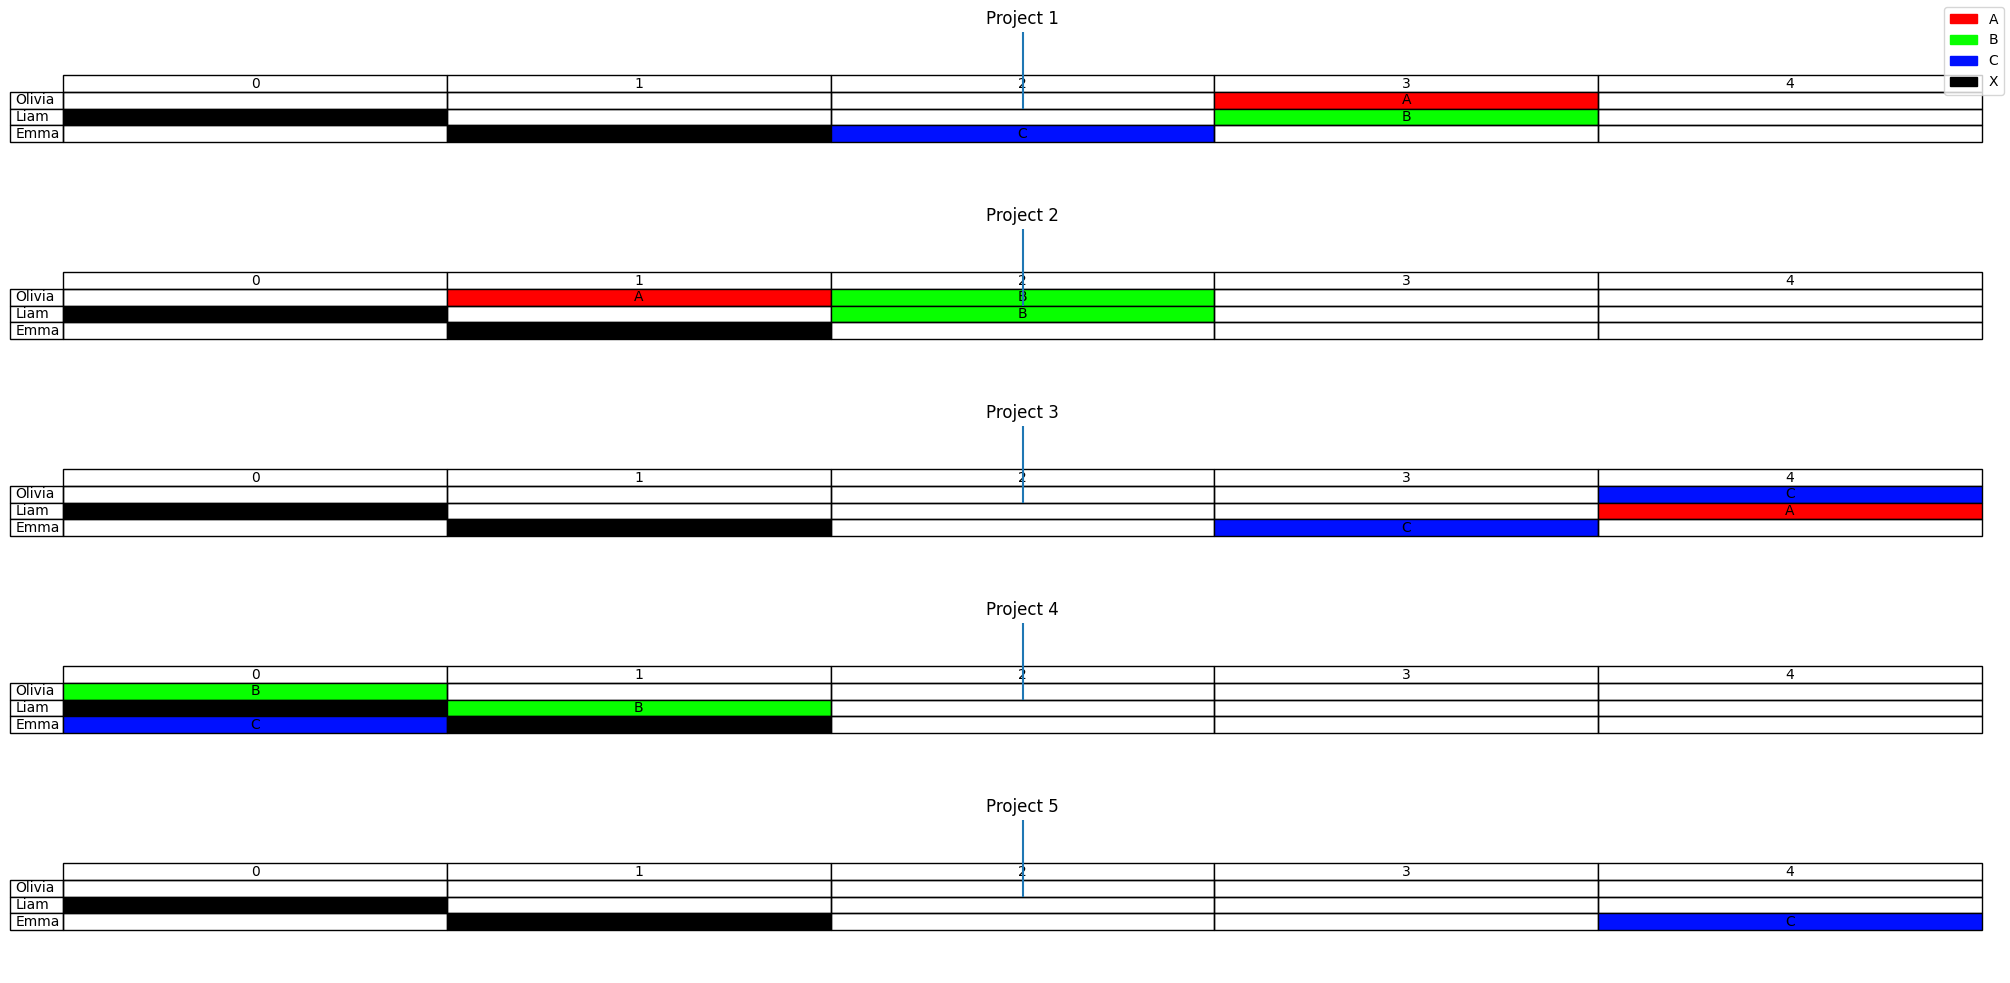

In [281]:
plot: Ploter = Ploter(m)

plot.gantt_projects()

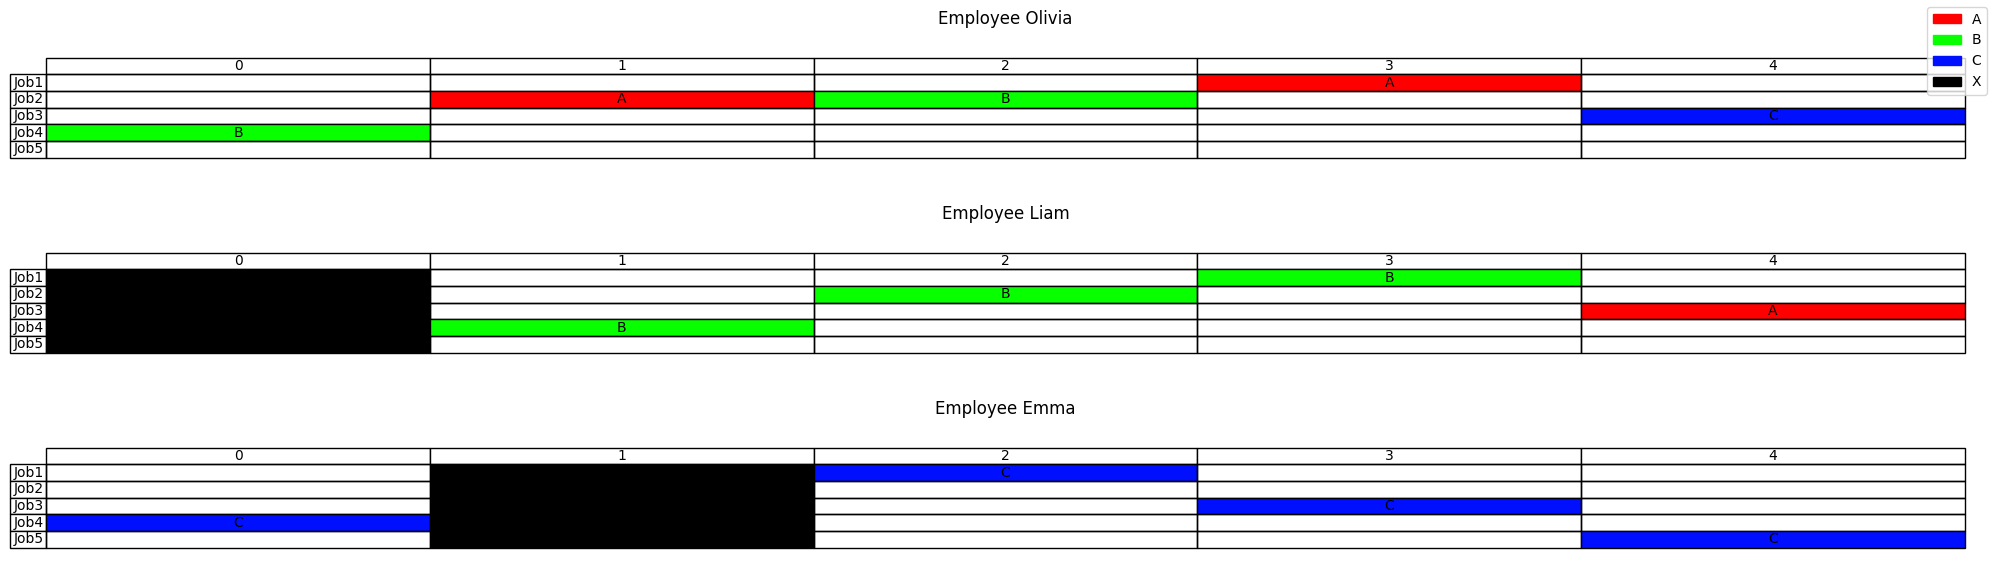

In [270]:
plot.gantt_employees()